In [1]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal # used to round the numbers so they look pretty

We consider the most basic within-flock SEIR model with $n$ species. We assume that all birds in a flock are of the same species, and all infectious birds are symptomatic, i.e. have the same infectiousness.

First we set the number of flocks in consideration and the population size in each flock.

In [2]:
# set number of species and population size

num_flocks = 3 # number of flocks
tot_popul = [500] * num_flocks # population size for each flock as a list


Set Initial conditions. The default assumes that all flocks are susceptible except for the 0th one which has one exposed bird.

In [3]:
# set initial conditions, row represents which species, column represents S, E, I, or R

# set size of matrix
init_val = np.zeros((num_flocks, 4)) 

# first set initial population to be all susceptible
init_val[:, 0] = tot_popul
    
# then let species 0 have one exposed
init_val[0, 0] -= 1
init_val[0, 1] += 1


In [4]:
# this is the maximum number of events that would occur, typically the number will not be reached, but 
# for diseases that does not die out this is necessary to not fall into an infinite while loop.
max_events = 500000

# set the time and state sequence
t = [0] + [None] * max_events
y = [init_val] + [None] * max_events


The parameters are as follows:

$\beta_{ij}$: The rate of infection from flock $i$ to flock $j$.

$\sigma_i$: Inverse of latency period of flock $i$.

$\gamma_i$: Inverse of infectious period of flock $i$.

In the code, all $\beta_{ij}$ parameters are packed in a matrix, and all $\sigma_i$ and $\gamma_i$ parameters are packed in a vector array.


In [5]:
# set parameters

# infection rate 
within_flock = 2
between_flock = 0.001
beta = np.diag([within_flock - between_flock] * num_flocks) + np.ones((num_flocks, num_flocks)) * between_flock # how ROW i infects COLUMN j

# latency and infectious period
latency_period = 1 * np.ones(num_flocks)
sigma = np.ones(num_flocks) / latency_period
infectious_period = 4 * np.ones(num_flocks)
gamma = np.ones(num_flocks) / infectious_period


We implement the Gillespie algorithm to generate the output. The update rules for a flock $i$ are given as follows:
$$ \begin{align*}
S_i &\xrightarrow{ \sum_{j} \frac{1}{N_j} \beta_{ji} I_j}E_i \\
E_i &\xrightarrow{\sigma_i} I_i \\
I_i &\xrightarrow{\gamma_i} R_i
\end{align*}
$$

The update rules are described in a event matrix. Specifically, let $\textbf{S} = [S_1, \ldots, S_n]$, $\textbf{E} = [E_1, \ldots, E_n]$, $\textbf{I} = [I_1, \ldots, I_n]$, $\textbf{R} = [R_1, \ldots, R_n]$. The update rules can be written (and implemented below) as:

$$ \begin{align*}
\textbf{S} &\xrightarrow{(\textbf{I}⊘\textbf{N})B} \textbf{E} \\
\textbf{E} &\xrightarrow{\Sigma} \textbf{I} \\
\textbf{I} &\xrightarrow{\Gamma} \textbf{R}
\end{align*}
$$

where $B, \Sigma, \Gamma$ are the beta matrix, sigma vector array, and gamma vector array respectively.

In [6]:
# run Gillespie

num_event = 0
current_val = init_val.copy()

while (num_event < max_events) and (np.sum(current_val[:,1:3]) > 0): # stop the loop if: 1. maximum event number is reached, or 2. no more infections can possibly occur.
     
    num_event += 1

    ##### create an event matrix ####

    all_events = np.zeros((num_flocks, 3)) # three types of update rules in total

    # this is implemented according to the markdown above
    all_events[:, 0] = np.multiply((current_val[:, 2] / tot_popul) @ beta, current_val[:, 0])
    all_events[:, 1] = np.multiply(sigma, current_val[:, 1]) 
    all_events[:, 2] = np.multiply(gamma, current_val[:, 2])

    # store total rate to rescale later
    tot_rate = np.sum(all_events)
    
    # do a time leap
    
    r1 = np.random.uniform()
    t[num_event] = t[num_event-1] - np.log(r1) / tot_rate
    
    # then choose events, first choose the type of events (S to E, E to I, or I to R)
    
    r2 = np.random.uniform()
    
    if r2 < np.sum(all_events[:, 0]) / tot_rate:
        type_event = 0
    elif r2 < np.sum(all_events[:, 0:2]) / tot_rate:
        type_event = 1
    else:
        type_event = 2
    
        
    # then choose which flock gets updated
    
    r3 = np.random.uniform()
    spec_event_rate = np.sum(all_events[:, type_event]) # total rate of a specific event occurring
    for i in range(num_flocks):
        if r3 < np.sum(all_events[0:i+1, type_event]) / spec_event_rate:
            current_val[i, type_event] -= 1
            current_val[i, type_event+1] += 1
            break
    
    y[num_event] = current_val.copy()


# get rid of none value if there is any:
t = np.array(t[0:num_event+1])
y = np.array(y[0:num_event+1])



Plot the output:

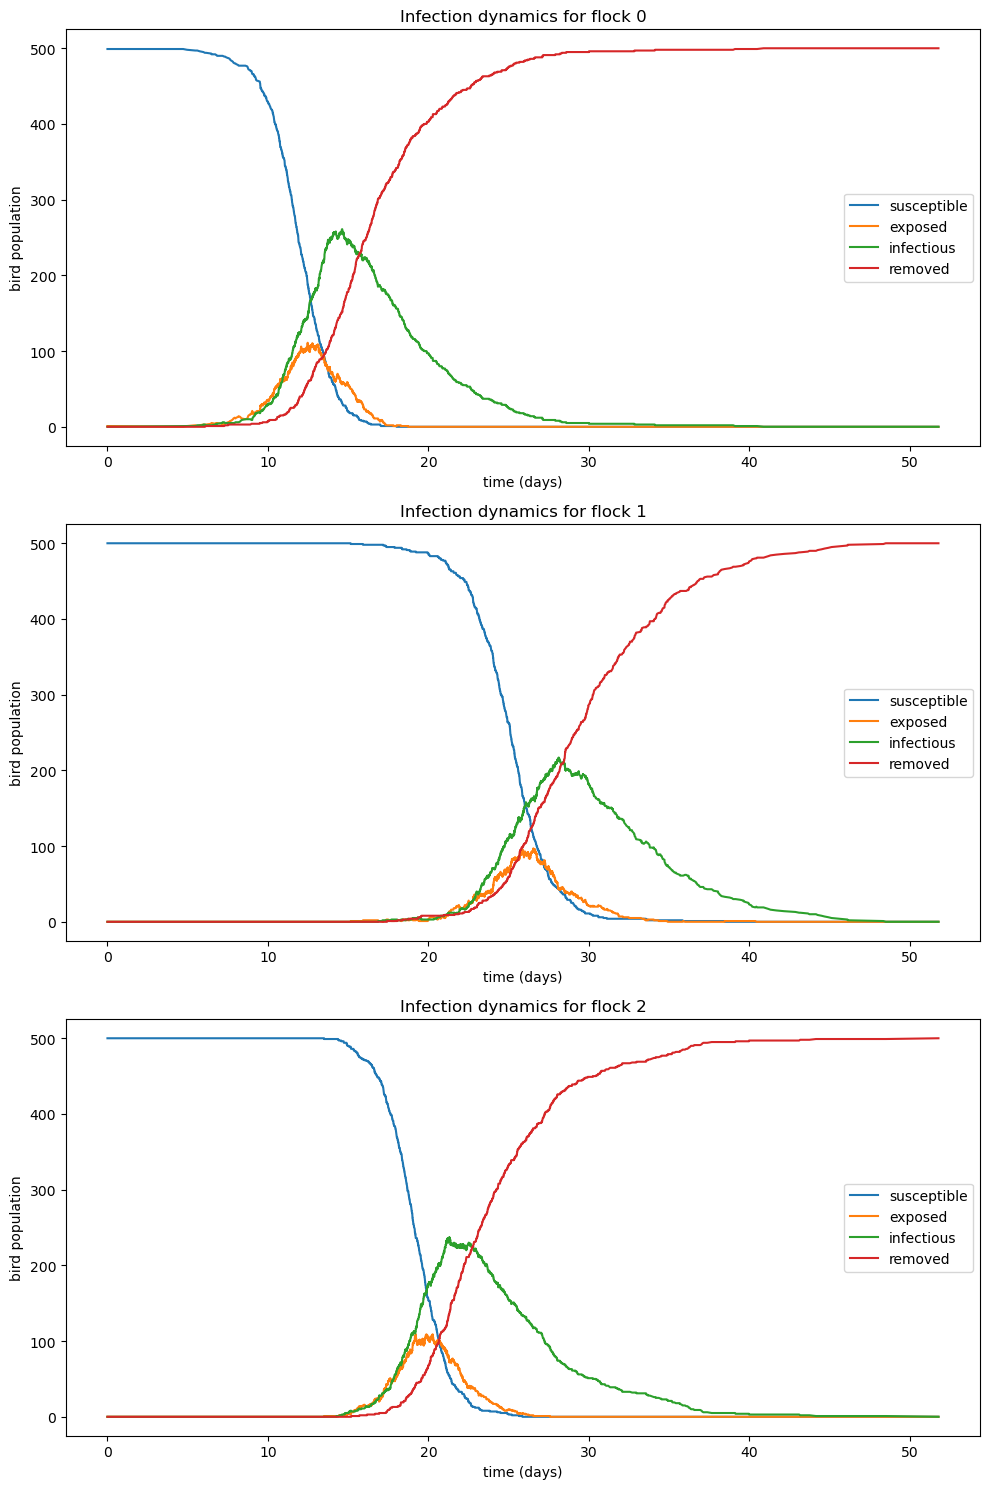

In [7]:
fig, axs = plt.subplots(num_flocks, 1, figsize=(10, 5*num_flocks))

if num_flocks == 1:
    axs = [axs]  # ensure axs is always iterable

for i, ax in enumerate(axs):
    # plot for bird i
    ax.plot(t, y[:, i, 0], label='susceptible')
    ax.plot(t, y[:, i, 1], label='exposed')
    ax.plot(t, y[:, i, 2], label='infectious')
    ax.plot(t, y[:, i, 3], label='removed')
    ax.legend()
    ax.set_xlabel('time (days)')
    ax.set_ylabel('bird population')
    ax.set_title(f'Infection dynamics for flock {i}')

plt.tight_layout()
plt.show()

Record key statistics:
- Whether an outbreak has occurred (Infectious population >= 10 at any point, both the population as a whole and individual flocks).
- Time of outbreak occurrence if there is an outbreak.
- The peak size of the epidemic, and when it occurred (both the population as a whole and individual flocks).
- The final size of the epidemic, and when it finished.

In [8]:
# Record key statistics

######## Outbreak statistics ########
outbreak_threshold = 10

# Outbreak or not
outbreak = len([state for state in y if np.sum(state[:,2]) >= outbreak_threshold]) > 0
outbreak = round(Decimal(outbreak), 2)

# if there is an outbreak, when does it happen
if outbreak:
    outbreak_time = t[[i for i, state in enumerate(y) if np.sum(state[:,2]) >= outbreak_threshold][0]]
    outbreak_time = round(Decimal(outbreak_time), 2)
    print(f'An outbreak has occurred, and it happened on {outbreak_time} days after the first exposure.')
else:
    outbreak_time = None
    print('An outbreak did not occur.')

# Which flocks are invaded by the virus
outbreak_indiv = [len([state for state in y if state[i,2] >= outbreak_threshold]) > 0 for i in range(num_flocks)]
outbreak_time_indiv = [t[[j for j, state in enumerate(y) if np.sum(state[i,2]) >= outbreak_threshold][0]] if outbreak_indiv[i] else None for i in range(num_flocks)]
outbreak_time_indiv = [round(Decimal(i), 2) if i != None else None for i in outbreak_time_indiv]

for i in range(num_flocks):
    if outbreak_indiv[i]:
        print(f'An outbreak in flock {i} occurred after {outbreak_time_indiv[i]} days')
    else:
        print(f'Outbreak did not occur in flock {i}')

An outbreak has occurred, and it happened on 8.60 days after the first exposure.
An outbreak in flock 0 occurred after 8.60 days
An outbreak in flock 1 occurred after 21.13 days
An outbreak in flock 2 occurred after 15.62 days


In [9]:
######## Peak size for all flocks as a whole ########
peak_size_whole = int(np.max([np.sum(state[:,2]) for state in y]))
peak_time_whole = t[np.argmax([np.sum(state[:,2]) for state in y])]
peak_time_whole = round(Decimal(peak_time_whole), 2)

print(f'The peak of the epidemic occurred after {peak_time_whole} days, with the total peak size {peak_size_whole}.')

######## Individual peak size ########
peak_size_indiv = np.amax([state[:,2] for state in y], axis=0)
peak_size_indiv = [int(i) for i in peak_size_indiv]

peak_time_indiv = [round(Decimal(t[i]), 2) for i in np.argmax([state[:,2] for state in y], axis=0)]

for i in range(num_flocks):
    print(f'The peak for flock {i} occurred after {peak_time_indiv[i]} days, with the flock peak size {peak_size_indiv[i]}')

The peak of the epidemic occurred after 21.20 days, with the total peak size 319.
The peak for flock 0 occurred after 14.62 days, with the flock peak size 261
The peak for flock 1 occurred after 28.12 days, with the flock peak size 217
The peak for flock 2 occurred after 21.30 days, with the flock peak size 237


In [10]:
######## Final size ########
final_size = y[-1][:,-1]
final_size = [int(i) for i in final_size]

end_time = t[-1]
end_time = round(Decimal(end_time), 2)

print(f'After {end_time} days:')
for i in range(num_flocks):
    print(f'the final number of removed birds in flock {i} is {final_size[i]}.')
    

After 51.79 days:
the final number of removed birds in flock 0 is 500.
the final number of removed birds in flock 1 is 500.
the final number of removed birds in flock 2 is 500.
